# Demo
1. Show two json files as the inputs
2. Post to terrarium funman api, show response id
3. Get result from id, and plot

# Todo
1. How to interact with terrarium
2. Setup API for two json files
3. Setup async anytime results
4. Truncate/halt request endpoint
5. Allow multiple requests in a queue, needs server thread

In [2]:
import asyncio
import nest_asyncio
import os
import json
from pathlib import Path

API_BASE_PATH = os.path.join(os.getcwd(), "..")
API_SERVER_HOST = "127.0.0.1"
API_SERVER_PORT = 8190
SERVER_URL = f"http://{API_SERVER_HOST}:{API_SERVER_PORT}"
OPENAPI_URL = f"{SERVER_URL}/openapi.json"
CLIENT_NAME = "funman-api-client"
RESOURCES = Path("../resources").resolve()

In [3]:
# Install API client to the working directory
# and add the install to the sys path
import funman.api.client as client
client.make_client(
    API_BASE_PATH, openapi_url=OPENAPI_URL, client_name=CLIENT_NAME
)

Updating existing funman client at /home/jladwig/funman from http://127.0.0.1:8190/openapi.json
Updating funman_api_client


In [4]:
# Setup API client request
from funman_api_client import Client
from funman_api_client.api.default import (
    post_queries_queries_post,
    get_queries_queries_query_id_get,
)
from funman_api_client.models.body_post_queries_queries_post import BodyPostQueriesQueriesPost
from funman_api_client.models import (
    BilayerModel,
    FUNMANConfig,
    LabeledParameter,
    QueryLE,
    FunmanWorkRequest,
    FunmanWorkUnit,
    FunmanResults
)

nest_asyncio.apply()
funman_client = Client(SERVER_URL, timeout=None)

In [5]:
# example paths
example_dir = RESOURCES / "funman" / "infected_threshold_example"
model_file = example_dir / "model.json"
request_file = example_dir / "request.json"

# read in json files
model = json.loads(model_file.read_bytes())
request = json.loads(request_file.read_bytes())

response = asyncio.run(
    post_queries_queries_post.asyncio_detailed(
        client=funman_client,
        json_body=BodyPostQueriesQueriesPost.from_dict({
            "model": model,
            "request": request
        }),
    )
)

work_unit = FunmanWorkUnit.from_dict(
    src_dict=json.loads(response.content.decode())
)
work_unit.id

'8ceb1ec5-ffe4-41e9-b9b3-00a66dcf075a'

In [12]:
response = asyncio.run(get_queries_queries_query_id_get.asyncio_detailed(
    work_unit.id,
    client=funman_client
))
results = FunmanResults.from_dict(
    src_dict=json.loads(response.content.decode())
)
results

FunmanResults(id='8ceb1ec5-ffe4-41e9-b9b3-00a66dcf075a', model=EncodedModel(name='model_166013e7-30c7-4c74-b8d4-7e20deb91b86', init_values=EncodedModelInitValues(additional_properties={'S': 9998.0, 'I': 1.0, 'R': 1.0}), parameter_bounds=EncodedModelParameterBounds(additional_properties={}), structural_parameter_bounds=EncodedModelStructuralParameterBounds(additional_properties={}), additional_properties={'bilayer': {'json_graph': {'Wa': [{'influx': 1, 'infusion': 2}, {'influx': 2, 'infusion': 3}], 'Win': [{'arg': 1, 'call': 1}, {'arg': 2, 'call': 1}, {'arg': 2, 'call': 2}], 'Box': [{'parameter': 'beta'}, {'parameter': 'gamma'}], 'Qin': [{'variable': 'S'}, {'variable': 'I'}, {'variable': 'R'}], 'Qout': [{'tanvar': "S'"}, {'tanvar': "I'"}, {'tanvar': "R'"}], 'Wn': [{'efflux': 1, 'effusion': 1}, {'efflux': 2, 'effusion': 2}]}}, 'measurements': None, 'identical_parameters': []}), request=FunmanWorkRequest(query=QueryLE(variable='I', ub=130.0, model=None, at_end=False, additional_properties

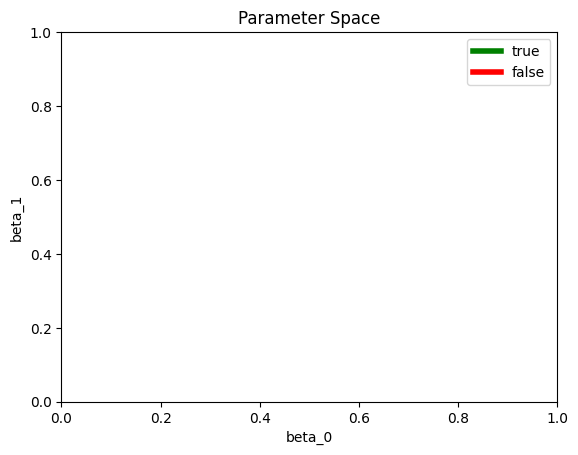

In [13]:
from funman_demo import plot
plot.plot_parameter_space(results.parameter_space, 1.0, True)